# A notebook with the FRB/US model
This notebook is based on the the FRB/US model packages located here (https://www.federalreserve.gov/econres/us-models-package.htm). The packages provides an Eviews (https://www.eviews.com/) implementation. The Eviews modelspecification has been transformed to ModelFlow BusinessLogic specification. 

In this notebook you can make your own experiments by updating variables. 

FRB/US comes in two flawors: **VAR** in which expectaions are generated by backward looking equations, and **MCE** in which expectation are based on leaded values. 
This notebook implement the **VAR** flavour. 

The tool used is highly experimental and the results are purely for illustration. 

You can run each cell by pressing the run tool or shift+enter
To run all cells use select cell/run all in the menu bar. 

# Import Python libraries

In [1]:
%matplotlib inline

import pandas as pd
from numba import jit


 
from modelclass import model  
import modelmf


# Prepare some stuff

In [2]:
turbo = 0  # Determines if the the model is compiled or not 

# define af function which is in Eviews but not in Python
@jit("f8(b1,f8,f8)")
def recode(condition,yes,no):
    '''Function which recratetes the functionality of @recode from eviews ''' 
    return yes if condition else no

# Load the model and the data 
The model and the data has been prepared in a preprocessor step. 

In [3]:
basedf  = pd.read_pickle('frbus/data/baseline.pc')

In [4]:
ffrbus  = open('frbus/model/ffrbusvar.txt','rt').read() 
# print(ffrbus)

# Create a model class instance

In [5]:
mfrbus = model(ffrbus,funks=[recode],modelname='FRB/US')

In [6]:
res = mfrbus(basedf,'2020q1','2025q4',max_iterations= 500,relconv=0.000000001,
             conv='XGDPN',ljit=turbo,silent=1,solver='sim')

# Run alternative 

In [7]:
# Make a new DataFrame
altdf = basedf.copy()

# Update variables in the dataframe
altdf=altdf.mfcalc('''\
rffintay_aerr = rffintay_aerr - 0.01
dmpex    = 0 
dmprr    = 0
dmptay   = 0
dmptlr   = 0 
dmpintay = 1
dmpalt   = 0
dmpgen   = 0

RFFMIN = 0.0
DMPTRSH = 0
'''.upper(),silent=1)

#Run the model 
with model.timer('Solve Frbus'):
    res2 = mfrbus(altdf,ldumpvar = 0,solver='newton',newton_absconv=0.0001)


Solve Frbus took       :         0.2482025623 Seconds


In [8]:
mfrbus.show_iterations('Rff',last=-5,change=1);

No iteration dump


In [9]:
trans = {'XGDPN':'GDP real terms (XGDPN)','RFF':'Federal Funds Rate (RFF)','GFSRPN':'Federal Budget surplus',
        'RFFMIN':'Minimum Fed Funds'}


# Show the results 

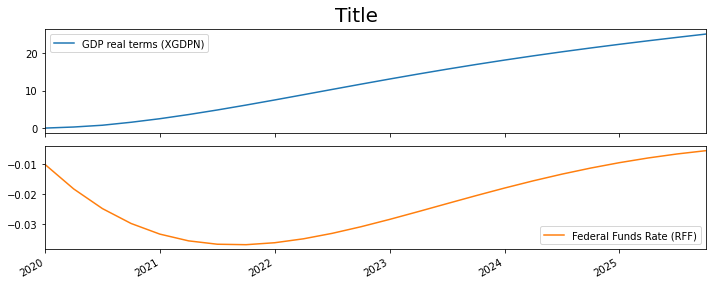

In [10]:
_ = mfrbus['XGDPN RFF'].dif.rename(trans).plot(colrow=1,sharey=0)

# Some interfaces 
. (dot) makes it easy to look at single variable. 

\[ \] (Slice) alows inspection of many variables selected with wildcars

# How is the interest rate determined

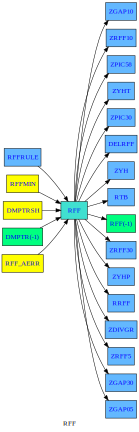

In [11]:
mfrbus.RFF.draw(up=1,down=1,HR=0,svg=1)

In [12]:
with mfrbus.set_smpl('2020q1','2020q4'):
    mfrbus.rff.show

Endogeneous: RFF 
Formular: FRML  <> RFF=(1-DMPTRSH)*(RECODE((RFFRULE)>(RFFMIN),RFFRULE,RFFMIN))+DMPTRSH*(RECODE(((DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN))>(RFFMIN),(DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN),RFFMIN))+RFF_AERR  $
Values : 
        2020Q1    2020Q2    2020Q3    2020Q4
Base  3.153624  3.250023  3.324873  3.378474
Last  3.143623  3.231767  3.299996  3.348577
Diff -0.010001 -0.018256 -0.024878 -0.029898

Input last run: 
                  2020Q1        2020Q2        2020Q3        2020Q4
DMPTR(-1)  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
DMPTRSH    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
RFFMIN     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
RFFRULE    3.143623e+00  3.231767e+00  3.299996e+00  3.348577e+00
RFF_AERR  -6.833184e-17 -6.833184e-17 -6.833184e-17 -6.833184e-17

Input base run: 
                  2020Q1        2020Q2        2020Q3        2020Q4
DMPTR(-1)  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
DMPTRSH    0.0000

In [13]:
with mfrbus.set_smpl('2020q1','2020q4'):
    mfrbus.rffintay.dekomp();

Formula        : FRML  <> RFFINTAY=.85*RFF(-1)+(1-.85)*(RSTAR+(PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4+0.5*((PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4-PITARG)+1.0*XGAP2)+RFFINTAY_AERR  $ 

                    2020Q1     2020Q2     2020Q3     2020Q4
Variable    lag                                            
Base        0     3.153624   3.250023   3.324873   3.378474
Alternative 0     3.143623   3.231767   3.299996   3.348577
Difference  0    -0.010001  -0.018256  -0.024878  -0.029898
Percent     0    -0.317135  -0.561736  -0.748237  -0.884948

 Contributions to differende for  RFFINTAY
                      2020Q1     2020Q2     2020Q3     2020Q4
Variable      lag                                            
RFF           -1    0.000000  -0.008501  -0.015518  -0.021146
RSTAR          0    0.000000   0.000000  -0.000000  -0.000000
PICXFE         0    0.000000   0.000006   0.000018   0.000032
              -1    0.000000   0.000000   0.000006   0.000018
              -2    0.000000   

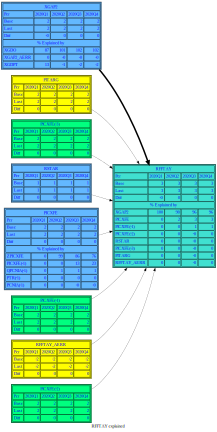

In [14]:
with mfrbus.set_smpl('2020q1','2020q4'):
     mfrbus.rfftay.explain(up=1,svg=1,pdf=0);

In [15]:
mfrbus['rffta* rffrule*']

          RFFTAY  RFFTAY_AERR   RFFRULE  RFFRULE_AERR
2020Q1  3.096487    -1.960046  3.143623  2.400000e-10
2020Q2  3.087534    -1.960046  3.231767  3.550000e-09
2020Q3  3.060561    -1.960046  3.299996 -5.000007e-11
2020Q4  3.016356    -1.960046  3.348577 -1.900001e-10
2021Q1  2.962286    -1.960046  3.377909 -5.300001e-10
2021Q2  2.890242    -1.960046  3.389690 -1.170000e-09
2021Q3  2.801868    -1.960046  3.386868 -2.240000e-09
2021Q4  2.701014    -1.960046  3.372661 -3.970000e-09
2022Q1  2.587061    -1.960046  3.350257 -6.833184e-17
2022Q2  2.470148    -1.960046  3.322728  1.000000e-11
2022Q3  2.354614    -1.960046  3.293028 -6.833184e-17
2022Q4  2.244195    -1.960046  3.264097 -1.000007e-11
2023Q1  2.144738    -1.960046  3.238547 -4.000007e-11
2023Q2  2.055024    -1.960046  3.217278 -1.000001e-10
2023Q3  1.974827    -1.960046  3.199490 -2.000001e-10
2023Q4  1.902713    -1.960046  3.184050 -3.400001e-10
2024Q1  1.837055    -1.960046  3.169937 -5.300001e-10
2024Q2  1.776752    -1.96004

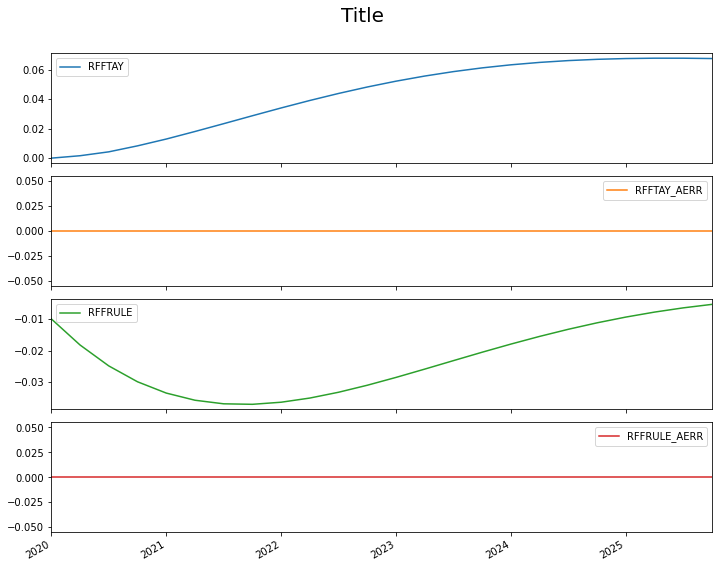

In [16]:
_ = mfrbus['rffta* rffrule*'].dif.plot(colrow=1,sharey=0)

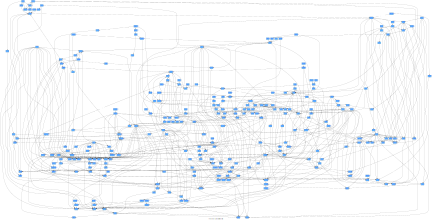

In [17]:
mfrbus.drawendo(lag=0,title='FRB/US endogeneous interpendencies',svg=1)
# you will find the output files in different format in the /graph folder

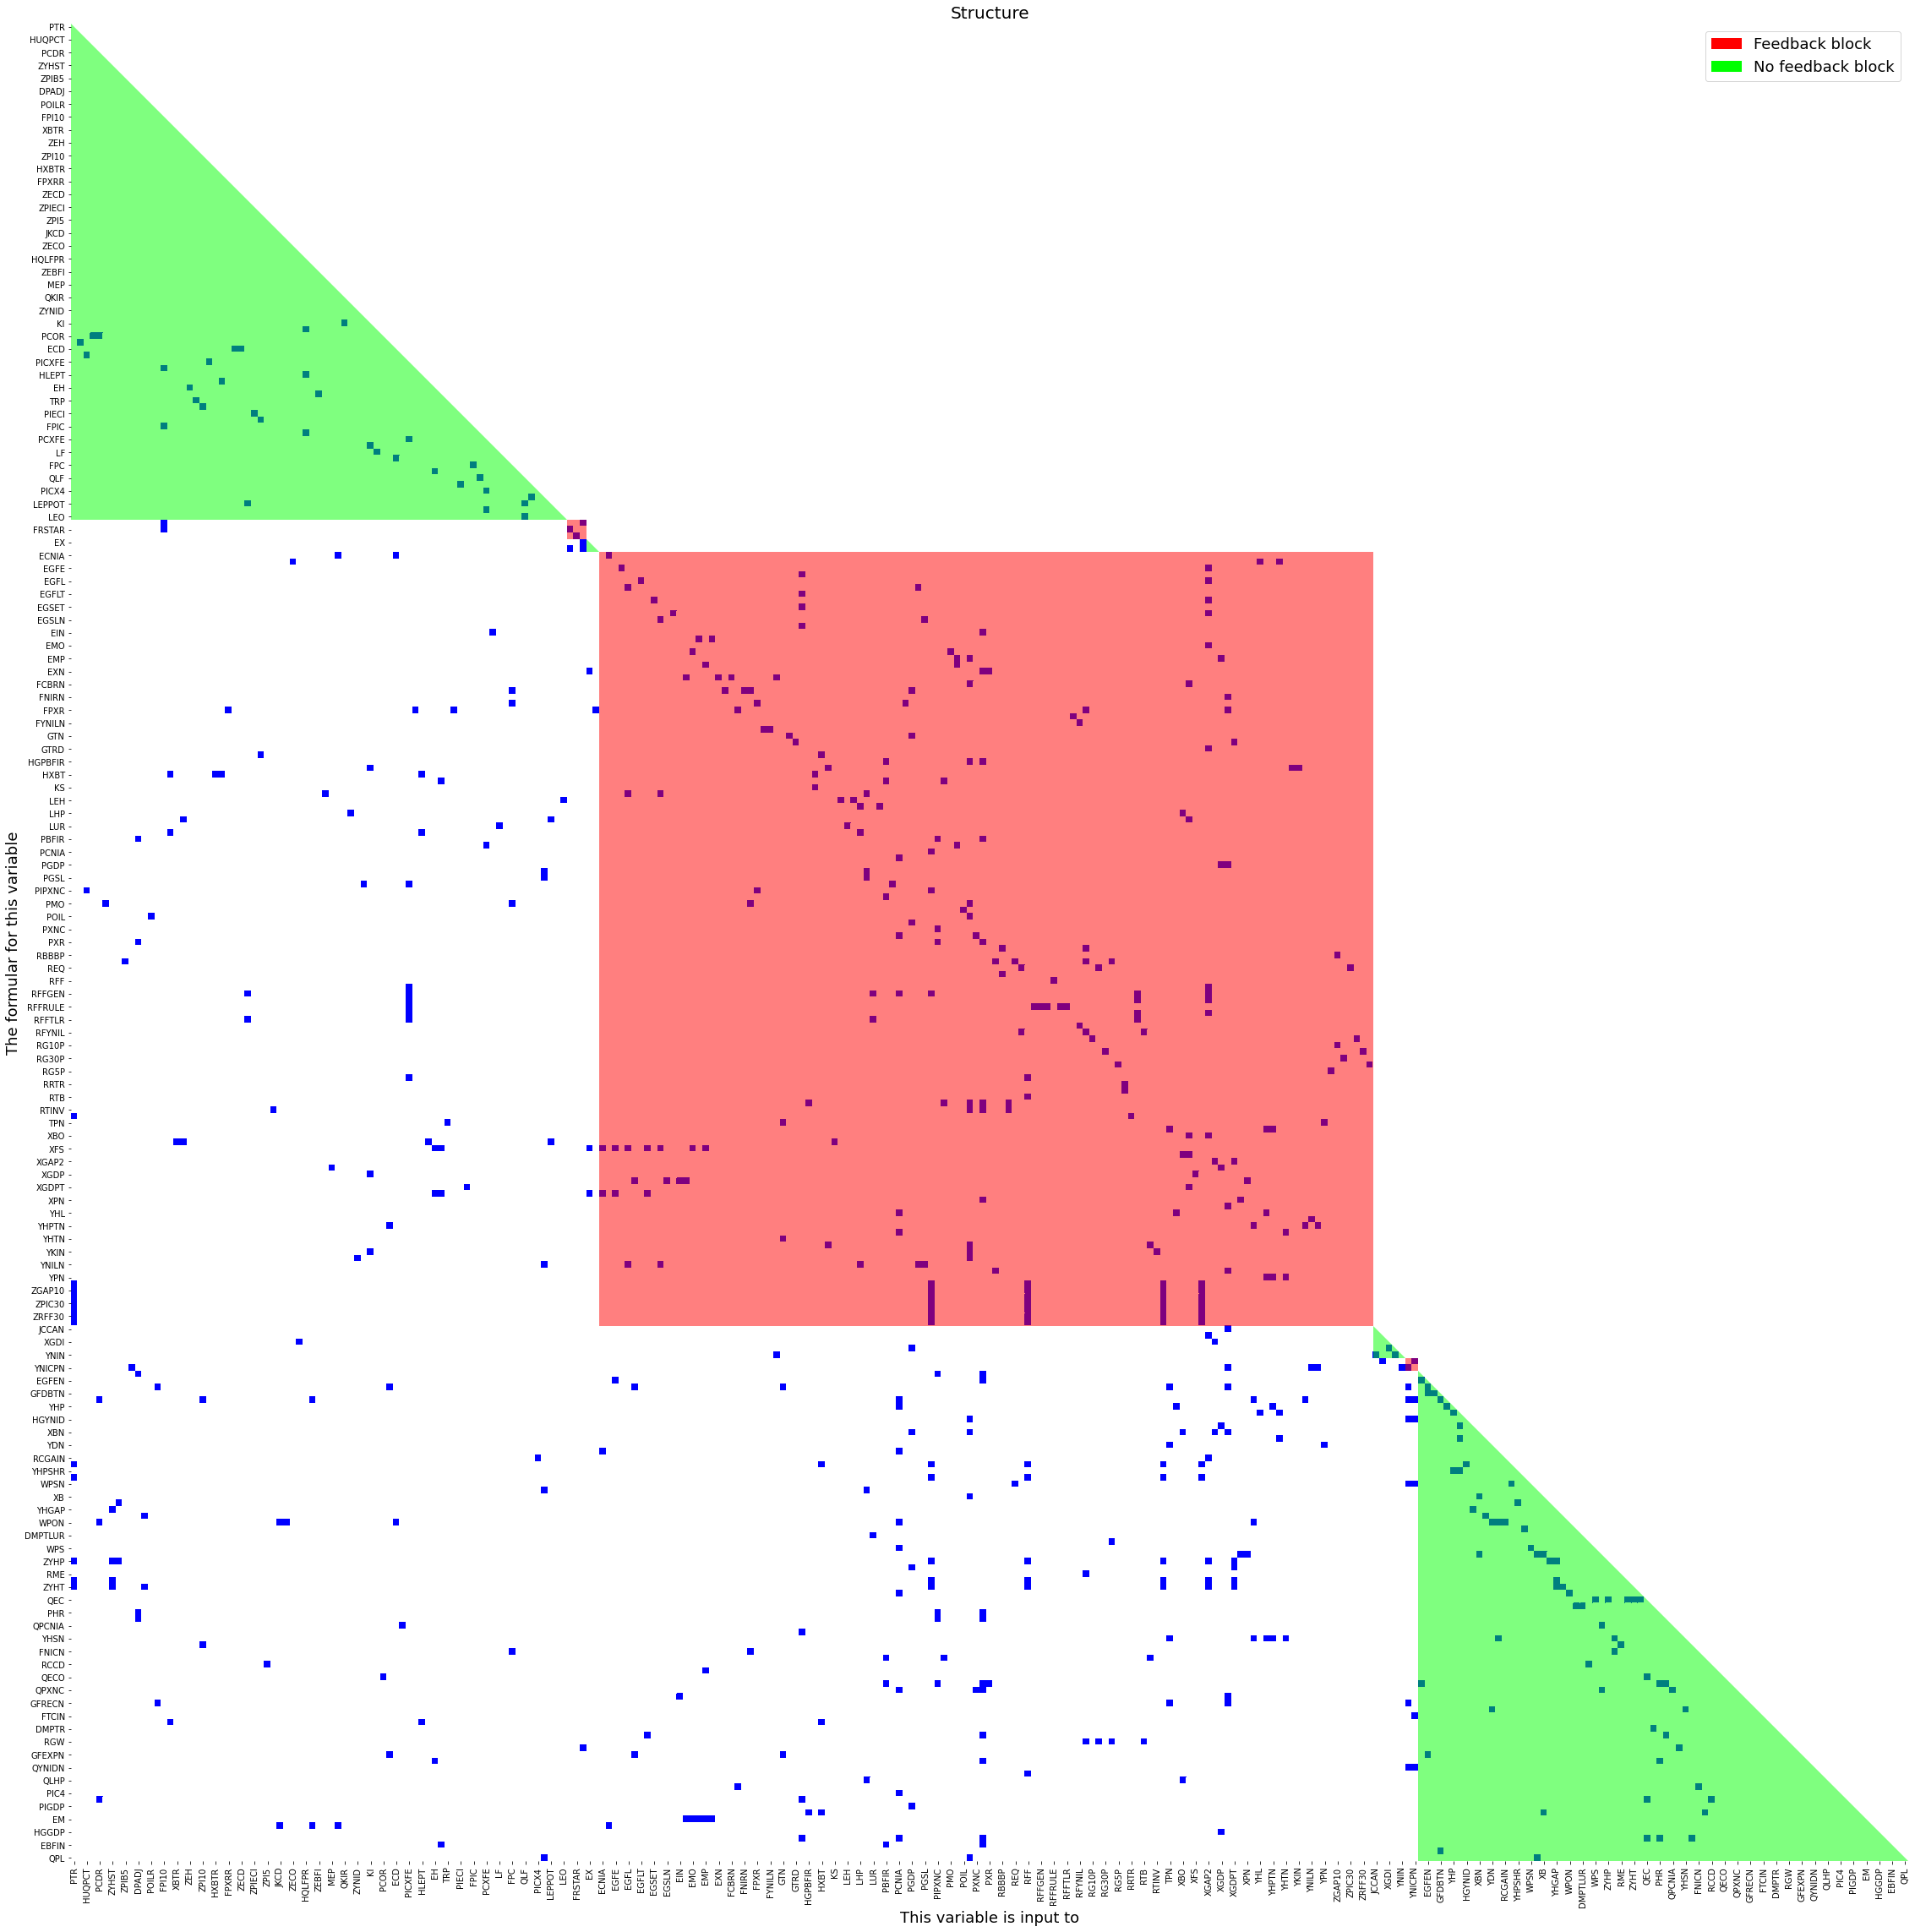

In [18]:
fig   = mfrbus.plotadjacency(size=(40,40))
#fig.savefig('graph/FRB-US causality structure.pdf')